# 05 Analyse

> Analyse metadata from publications.

In [ ]:
#|default_exp core.05_analyse

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#|hide
from nbdev.showdoc import show_doc

In [ ]:
#|export
import pubcrawler as proj
from pubcrawler import const, log, utils, tools
import adu_proj.utils as adutils

In [ ]:
#|export
from collections import Counter
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import re
import itertools
import networkx as nx
from pyvis.network import Network
import shutil
from fuzzywuzzy import fuzz
import pandas as pd
import re
import plotly.express as px
from dateutil.parser import parse
from dateutil.parser._parser import ParserError
import plotly
import networkx as nx
import plotly.graph_objs as go
import itertools
from pandas.errors import EmptyDataError

In [ ]:
plotly.offline.init_notebook_mode(connected=True)

In [ ]:
# |export
fm.fontManager.addfont(f'{const.style_path}/fonts/JosefinSans-Regular.ttf')
plt.style.use(f'{const.style_path}/autonomy_white.mplstyle')
pd.set_option('display.max_colwidth', None)

In [ ]:
#|export
plots_dir = f'{const.pre_output_path}/plots'
os.makedirs(plots_dir, exist_ok=True)

In [ ]:
#|export
try:
    pubs = pd.read_csv(f"{const.pre_output_path}/pub_metadata.csv")
except EmptyDataError:
    raise Exception(f"No publications were found for {const.directory_name}")

const.org_namesFilter for publications containing the org name in the list of organisations:

In [ ]:
#|export
org_names = [name for name in [const.org_name, const.org_name_2, const.org_name_3] if name]

['oxford global society']

In [ ]:
#|export
org_pubs = pubs[pubs['organisation'].str.contains('|'.join(org_names), na=False, case=False)].reset_index(drop=True)

## Author Frequency

We can begin by analysing which authors appear most across all publications.

In [ ]:
#|export
authors = [item for sublist in org_pubs['authors'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
#|export
author_frequency = Counter(authors)

We may encounter slightly different versions of the same name so its worth grouping very similar names using fuzzy matching:

In [ ]:
#|export
def find_best_match(name: str, # single name
                    names: list # list of names
                   ):
    "Find best match in a list of names"
    best_score, best_match = 0, None
    for n in names:
        score = fuzz.ratio(name, n)
        if score > best_score:
            best_score, best_match = score, n  # Corrected this line
    return best_match

In [ ]:
find_best_match("John", ["John Doe", "Joe Doe", "Josh Jo"])

'John Doe'

In [ ]:
#|export
threshold = 85  # similarity threshold, can adjust as needed
grouped_author_counts = Counter()
for name, count in author_frequency.items():
    match = find_best_match(name, grouped_author_counts)
    if match and fuzz.ratio(name, match) >= threshold:
        grouped_author_counts[match] += count
    else:
        grouped_author_counts[name] = count

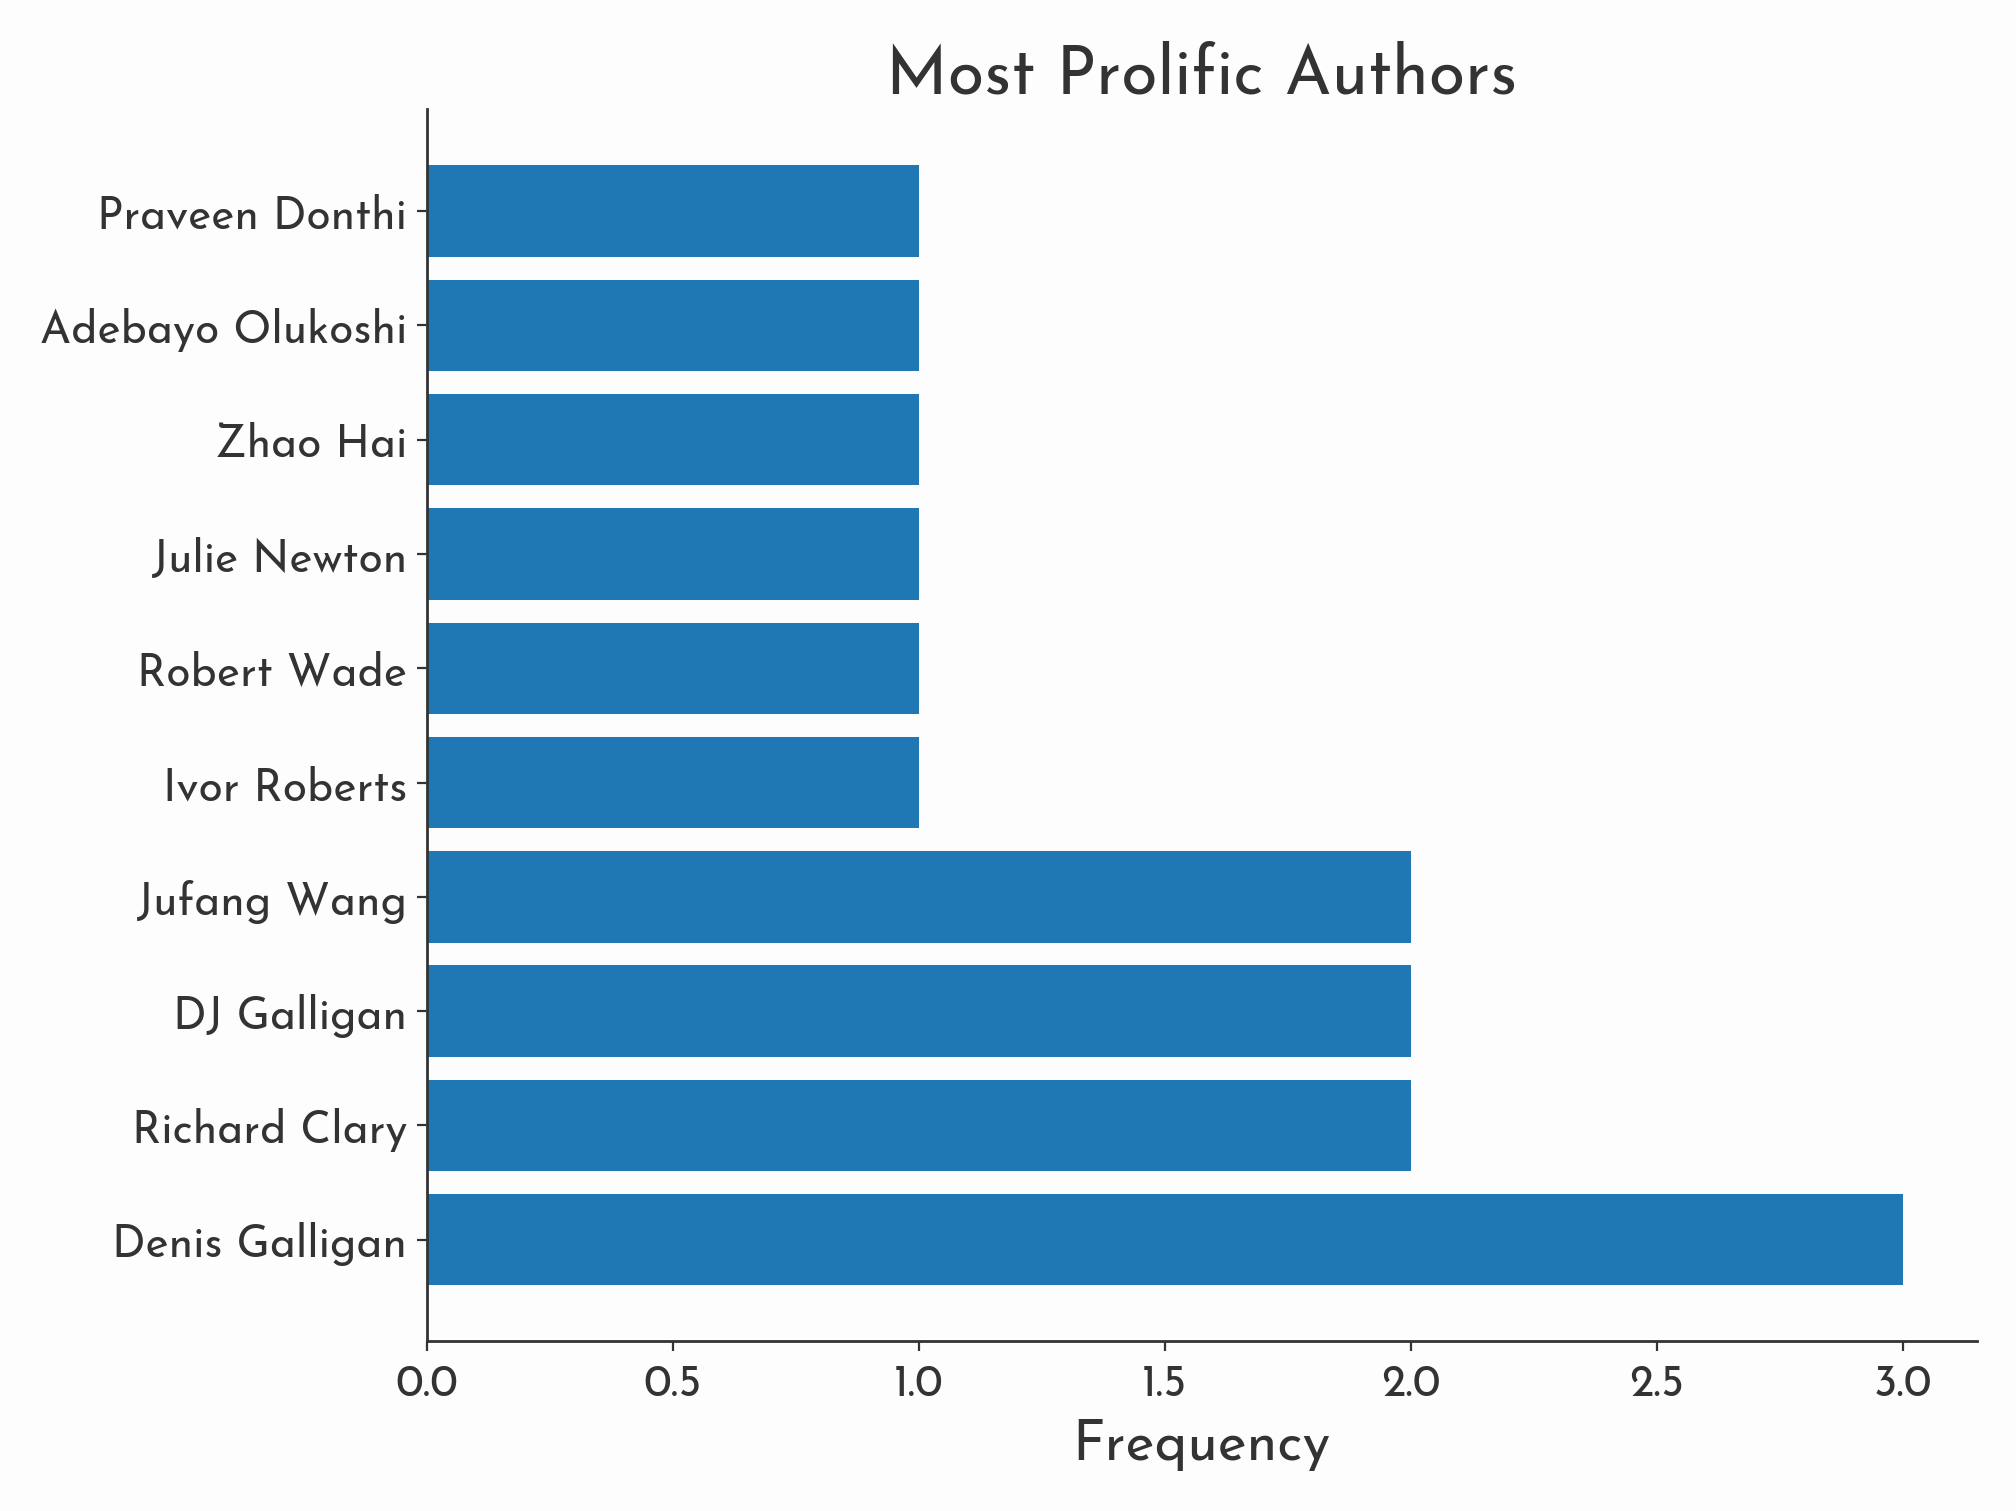

In [ ]:
#|export
top_10_authors = grouped_author_counts.most_common(10)

if top_10_authors:
    # Separating items and their frequencies
    items, frequencies = zip(*top_10_authors)

    # Creating a horizontal bar chart
    plt.figure(figsize=(10, 8))  # Adjust size as needed
    plt.barh(items, frequencies)
    plt.xlabel('Frequency')
    plt.title('Most Prolific Authors')
    plt.savefig(f'{plots_dir}/author_frequency.png')

In [ ]:
plt.show()

## Organisation Frequency

Lets see the most common organisations to author publications:

In [ ]:
#|export
organisations = [item for sublist in org_pubs['organisation'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
#|export
organisations = [organisation for organisation in organisations if all(name not in organisation.lower() for name in org_names)]

In [ ]:
#|export
organisation_frequency = Counter(organisations)

In [ ]:
#|export
threshold = 85  # similarity threshold, can adjust as needed
grouped_org_counts = Counter()
for name, count in organisation_frequency.items():
    match = find_best_match(name, grouped_org_counts)
    if match and fuzz.ratio(name, match) >= threshold:
        grouped_org_counts[match] += count
    else:
        grouped_org_counts[name] = count

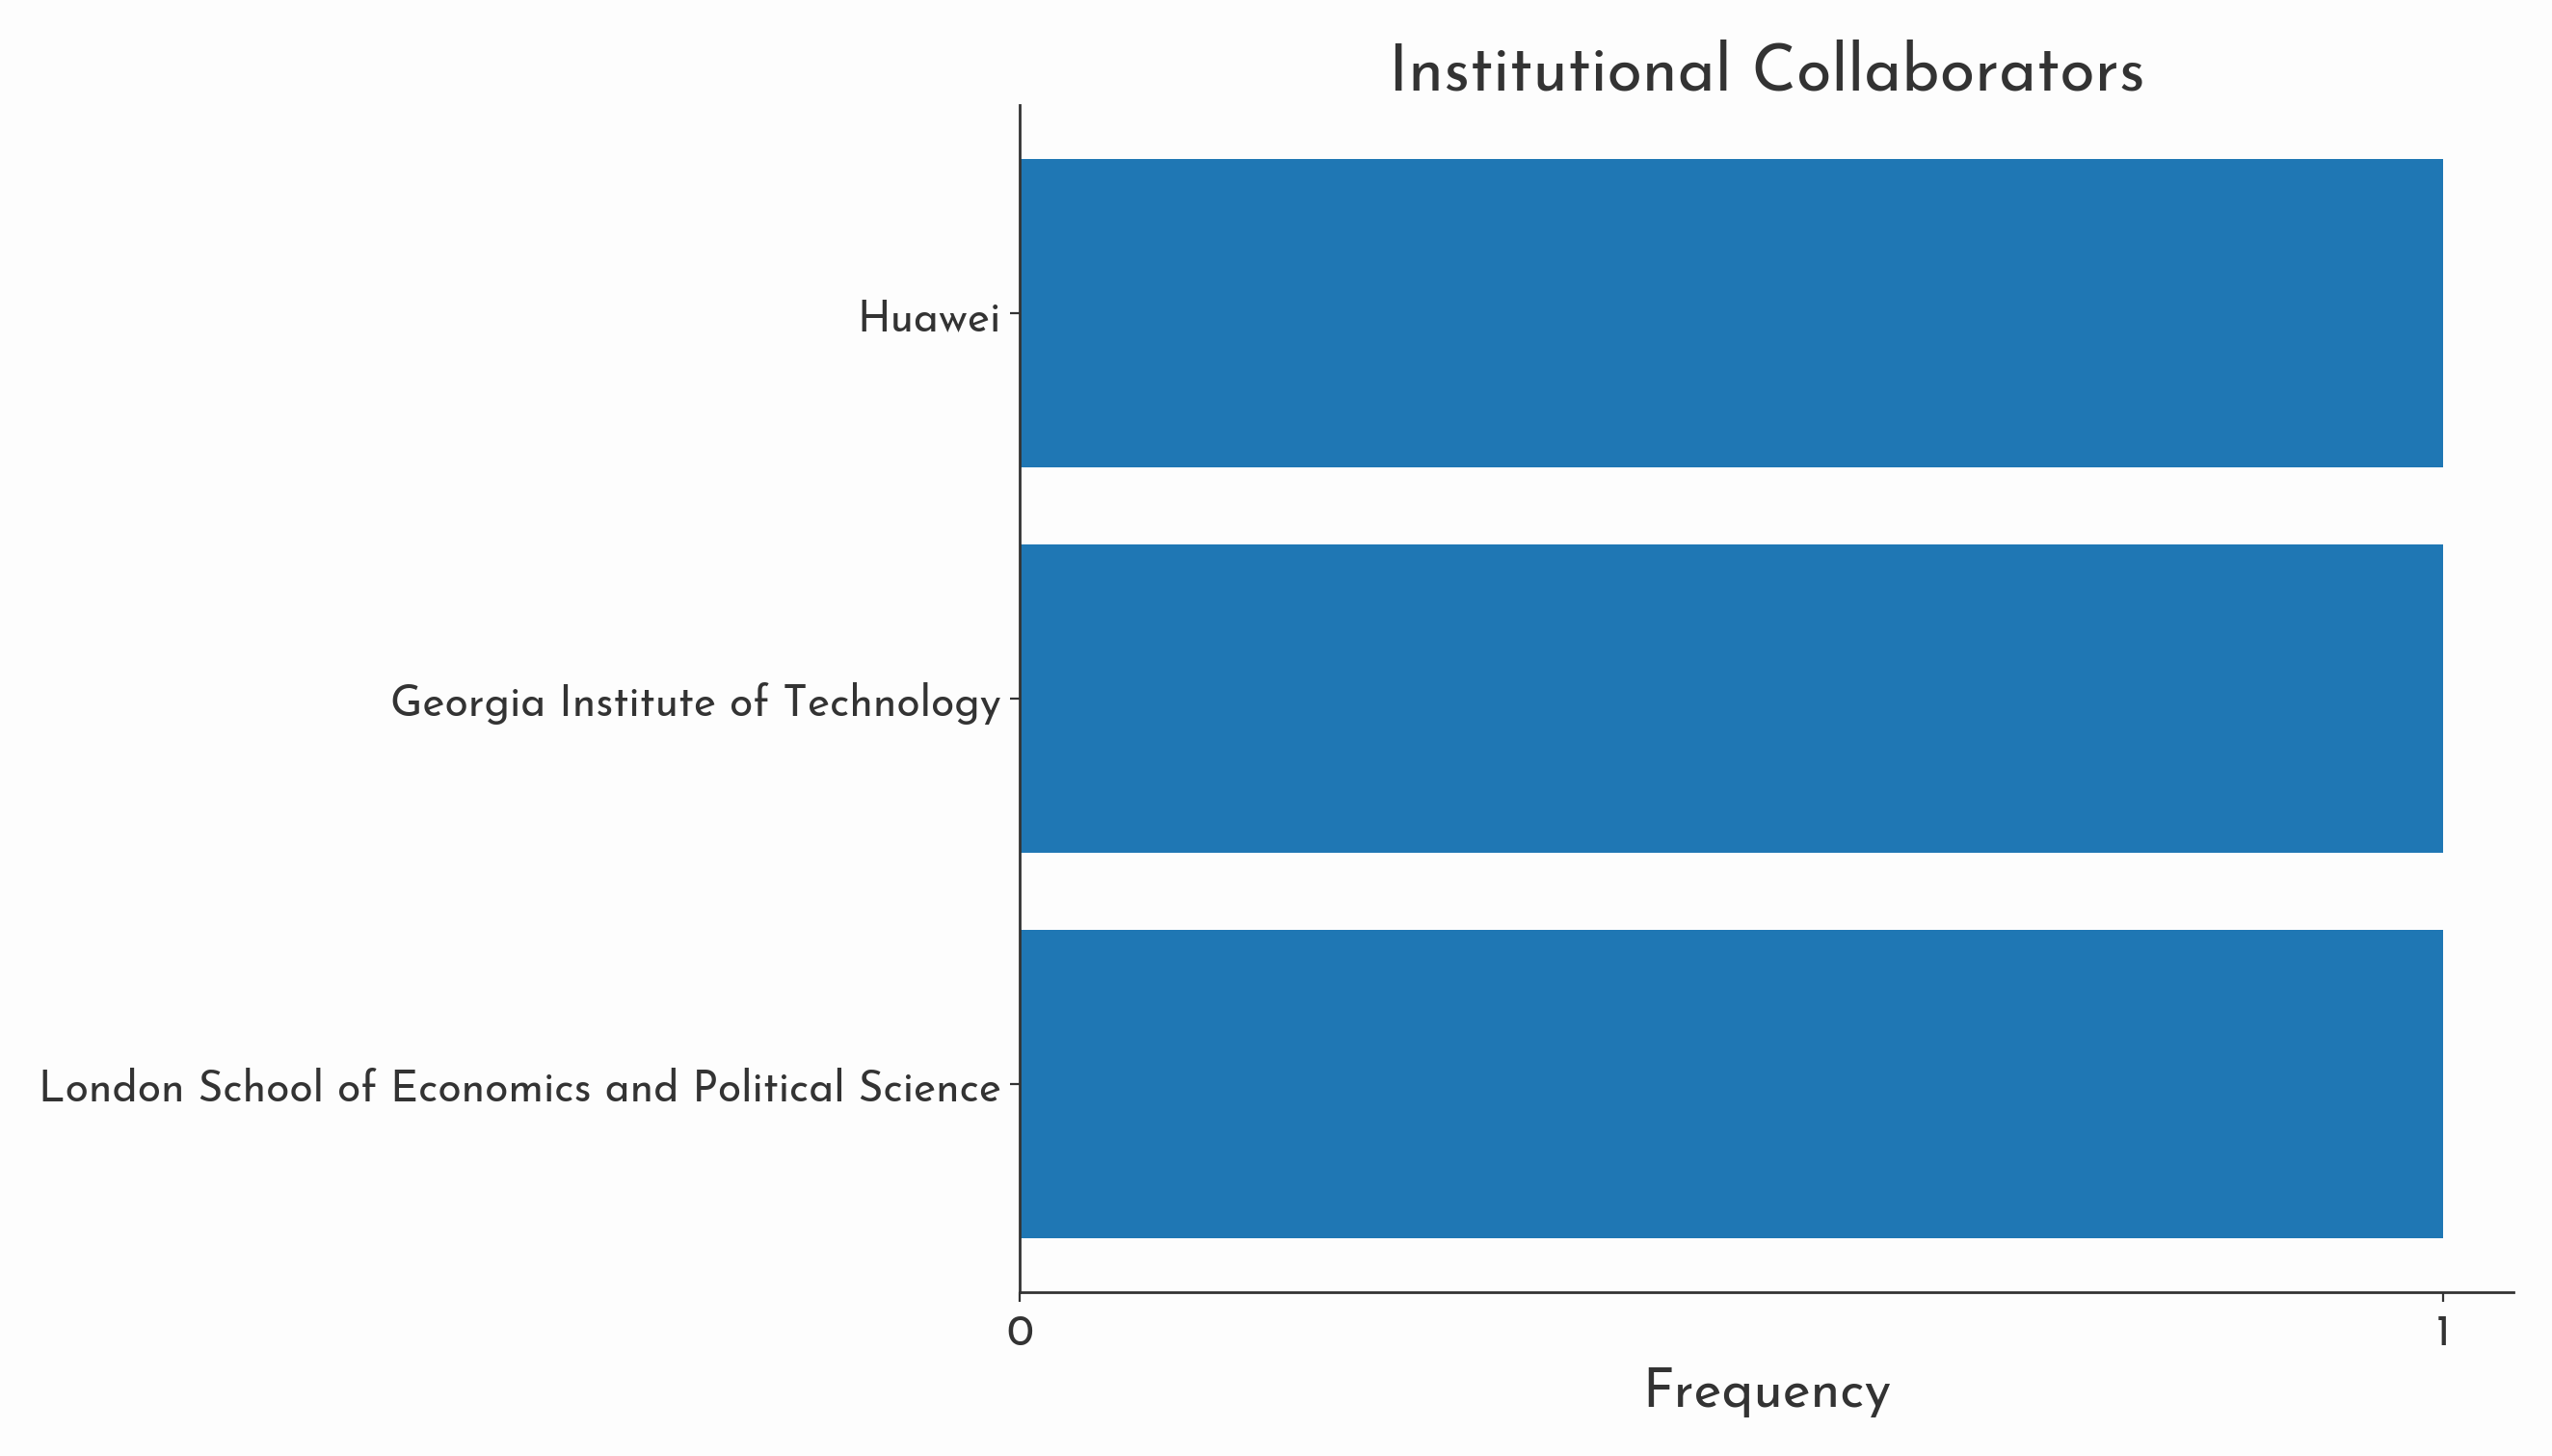

In [ ]:
#|export
top_10_orgs = grouped_org_counts.most_common(10)

if top_10_orgs:
    # Separating items and their frequencies
    items, frequencies = zip(*top_10_orgs)

    # Creating a horizontal bar chart
    plt.figure(figsize=(10, 8))  # Adjust size as needed
    plt.barh(items, frequencies)
    plt.xlabel('Frequency')
    plt.title('Institutional Collaborators')
    # Set x-axis ticks to show only complete numbers
    max_frequency = max(frequencies)
    step = 1  # Define step size based on your data scale
    plt.xticks(range(0, max_frequency + 1, step))
    plt.savefig(f'{plots_dir}/organisation_frequency.png')

In [ ]:
plt.show()

## Funder Frequency

In [ ]:
#|export
funders = [item for sublist in org_pubs['funders'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
#|export
funders = [organisation for organisation in funders if all(name not in organisation.lower() for name in org_names)]

In [ ]:
#|export
funder_frequency = Counter(funders)

In [ ]:
#|export
threshold = 85  # similarity threshold, can adjust as needed
grouped_funder_counts = Counter()
for name, count in funder_frequency.items():
    match = find_best_match(name, grouped_funder_counts)
    if match and fuzz.ratio(name, match) >= threshold:
        grouped_funder_counts[match] += count
    else:
        grouped_funder_counts[name] = count

In [ ]:
#|export
top_10_funders = grouped_funder_counts.most_common(10)

if top_10_funders:
    # Separating items and their frequencies
    items, frequencies = zip(*top_10_funders)

    # Creating a horizontal bar chart
    plt.figure(figsize=(10, 8))  # Adjust size as needed
    plt.barh(items, frequencies)
    plt.xlabel('Frequency')
    plt.title('Most Regular Funders')
    plt.savefig(f'{plots_dir}/funder_frequency.png')

In [ ]:
plt.show()

## Keyword Frequency

In [ ]:
#|export
keywords = [item.lower() for sublist in org_pubs['keywords'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
#|export
keyword_frequency = Counter(keywords)

In [ ]:
#|export
threshold = 85  # similarity threshold, can adjust as needed
grouped_keyword_counts = Counter()
for name, count in keyword_frequency.items():
    match = find_best_match(name, grouped_keyword_counts)
    if match and fuzz.ratio(name, match) >= threshold:
        grouped_keyword_counts[match] += count
    else:
        grouped_keyword_counts[name] = count

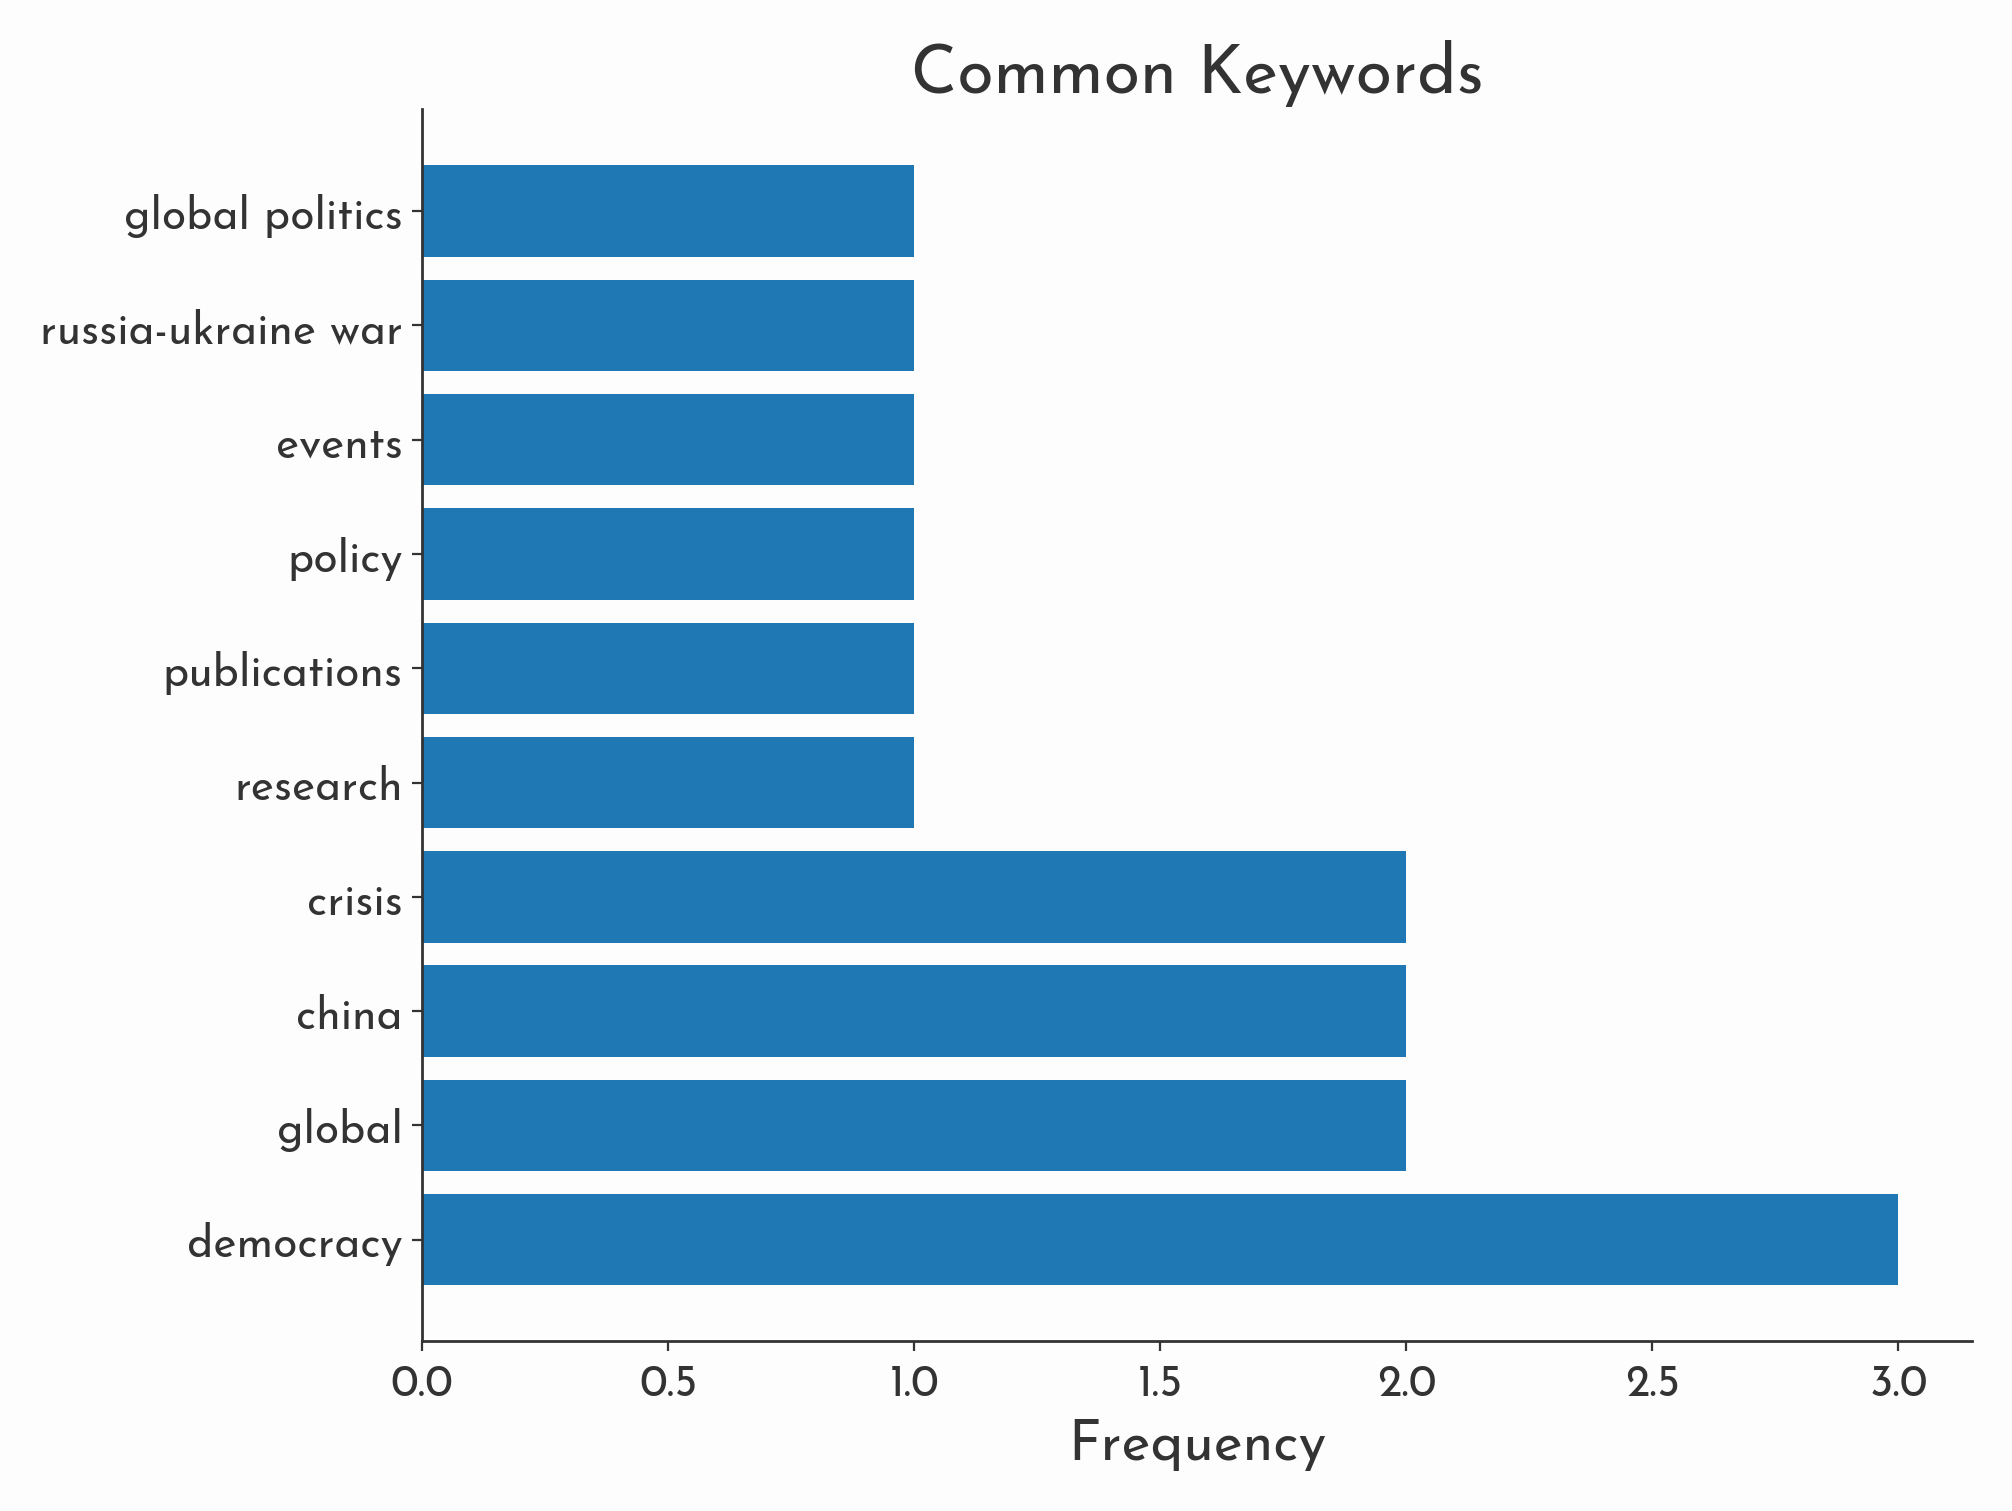

In [ ]:
#|export
top_10_keywords = grouped_keyword_counts.most_common(10)

if top_10_keywords:
    # Separating items and their frequencies
    items, frequencies = zip(*top_10_keywords)

    # Creating a horizontal bar chart
    plt.figure(figsize=(10, 8))  # Adjust size as needed
    plt.barh(items, frequencies)
    plt.xlabel('Frequency')
    plt.title('Common Keywords')
    plt.savefig(f'{plots_dir}/keyword_frequency.png')

In [ ]:
plt.show()

## Publication Frequency

In [ ]:
#|export
def extract_year(text):
    match = re.search(r'\d{4}', text)
    return match.group(0) if match else None

In [ ]:
#|export
org_pubs['year'] = org_pubs['date'].apply(lambda x: extract_year(str(x)))

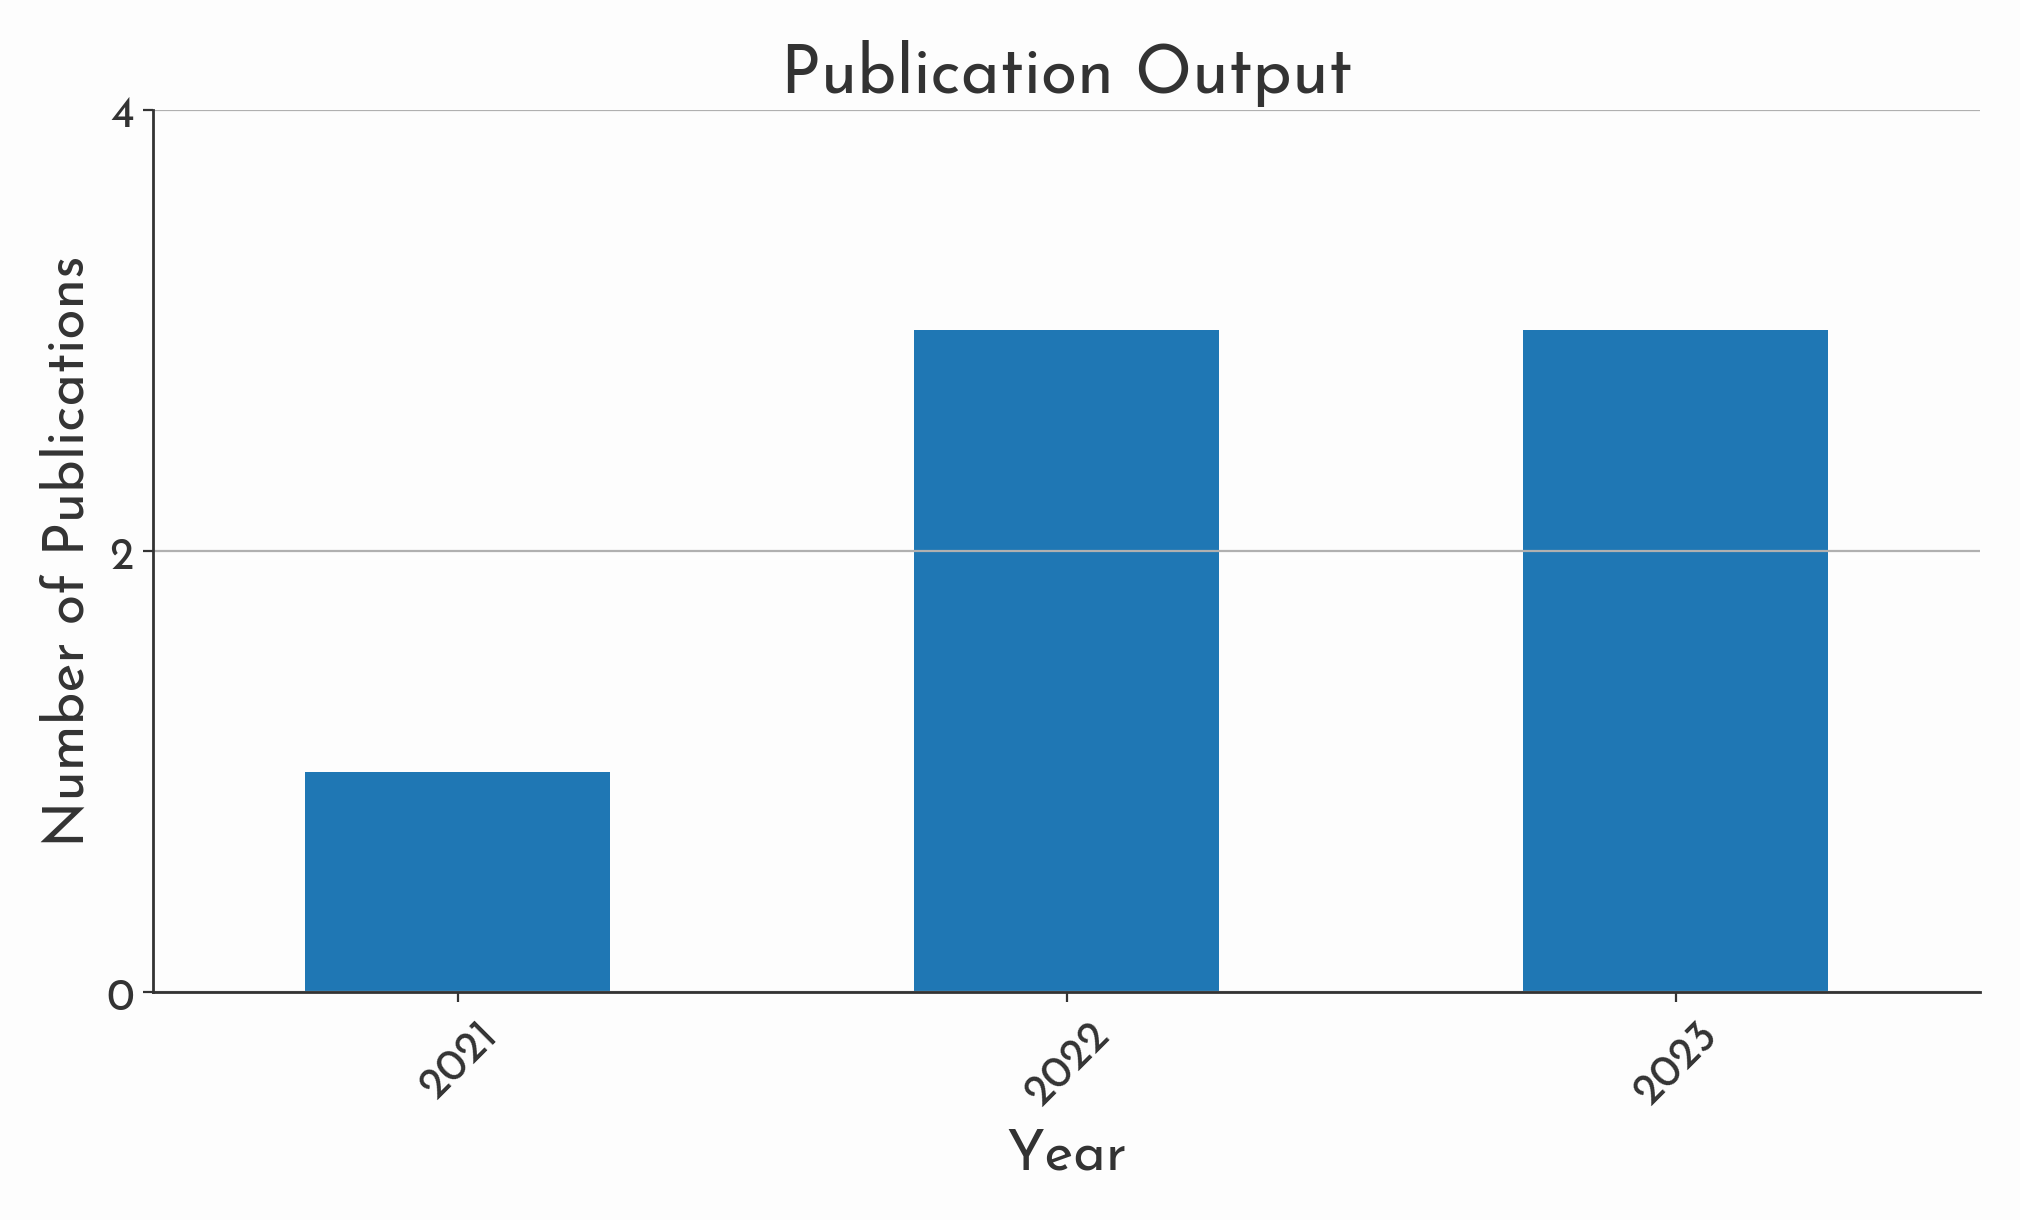

In [ ]:
#|export
year_counts = org_pubs['year'].dropna().astype(int).value_counts().sort_index()
if not year_counts.empty:
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind='bar')
    plt.title('Publication Output')
    plt.xlabel('Year')
    plt.ylabel('Number of Publications')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    max_frequency = max(year_counts)
    step = 2 
    plt.yticks(range(0, max_frequency + 2, step))
    plt.tight_layout()
    plt.savefig(f'{plots_dir}/publication_output.png')

In [ ]:
plt.show()

## Publication Frequency (Monthly)

In [ ]:
#|export
def contains_month_and_year(date_str:str
                           ):
    "return month and year from date string"
    # Regex pattern for standalone year (e.g., '2023')
    if not isinstance(date_str, str):
        return False
    year_pattern = r'^\d{4}$'
    if re.match(year_pattern, date_str):
        return False
    try:
        parsed_date = parse(date_str)
        # Check if both month and year are present
        return parsed_date.month != 1 or parsed_date.year != parsed_date.today().year
    except ParserError:
        return False

In [ ]:
#|export
def split_text(text:str):
    "new line for every 5 words"
    words = text.split()
    return '<br>'.join(' '.join(words[i:i+5]) for i in range(0, len(words), 5))

In [ ]:
#|export
org_pubs['date_parsed'] = org_pubs['date'].apply(contains_month_and_year)

In [ ]:
#|export
org_pubs_monthly = org_pubs[org_pubs['date_parsed']].copy()
org_pubs_monthly['report'] = org_pubs_monthly['title'].apply(split_text)
org_pubs_monthly['date'] = pd.to_datetime(org_pubs_monthly['date'], errors='ignore', format='mixed')
org_pubs_monthly['month_year'] = org_pubs_monthly['date'].dt.to_period('M')
org_pubs_monthly = org_pubs_monthly.drop_duplicates(subset=['report', 'date'], keep='first')
org_pubs_monthly['cumulative_count'] = org_pubs_monthly.groupby('month_year').cumcount() + 1

if not org_pubs_monthly.empty:
    fig = px.scatter(org_pubs_monthly, x='date', y='cumulative_count', title='Publication Output (Monthly)', 
                     hover_data={'report': True, 'date': True, 'cumulative_count': False},
                     size_max=60)
    fig.update_traces(marker=dict(color='#E3BA59'))
    fig.update_traces(textposition='top center')
    fig.update_layout(xaxis_title='Date', yaxis_title=None, 
                      yaxis=dict(tickmode='linear', tick0=1, dtick=1, gridcolor='#878787'),
                      xaxis=dict(gridcolor='#878787'),
                      font=dict(family="Josefin Sans, Arial"),
                      hoverlabel=dict(
                          font=dict(family="Josefin Sans, Arial", color="#FFFFFF"),
                          bgcolor="#222222"
                      ),
                      plot_bgcolor='#333333', showlegend=False)
    html_filename = "publication_monthly.html"
    fig.write_html(f'{plots_dir}/{html_filename}')

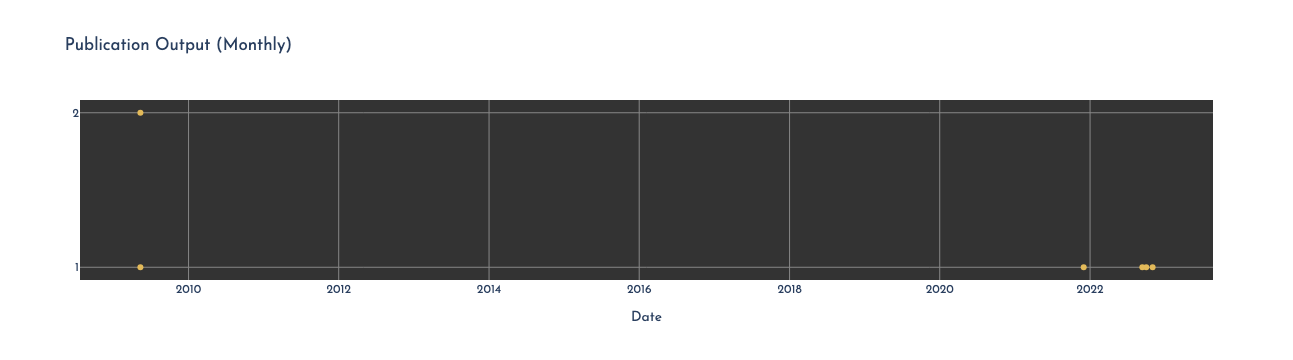

In [ ]:
fig.show()

## Co-author Frequency

In [ ]:
#|export
author_lists = [ast.literal_eval(sublist) for sublist in org_pubs['authors'] if isinstance(ast.literal_eval(sublist), list)]

In [ ]:
#|export
if author_lists:
    G = nx.Graph()

    if not author_lists:
        print("author_lists is empty.")
    else:
        for sublist in author_lists:
            for pair in itertools.combinations(sublist, 2):
                if G.has_edge(*pair):
                    G[pair[0]][pair[1]]['weight'] += 1
                else:
                    G.add_edge(pair[0], pair[1], weight=1)
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("No nodes or edges in the graph.")
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        pos = nx.spring_layout(G)
        nx.set_node_attributes(G, pos, 'pos')
        central_node = max(G.nodes, key=lambda n: G.degree(n))
        central_pos = G.nodes[central_node]['pos']
        zoom_range = 0.2  # Adjust the value as needed for the desired zoom level
        x_range = [central_pos[0] - zoom_range, central_pos[0] + zoom_range]
        y_range = [central_pos[1] - zoom_range, central_pos[1] + zoom_range]
        edge_traces = []
        for edge in G.edges():
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            weight = G[edge[0]][edge[1]]['weight']
            # weight_text = f"Collaborations: {weight}"

            edge_trace = go.Scatter(
                x=[x0, x1, None], y=[y0, y1, None],
                line=dict(width=0.5*weight, color='#888'),
                # hoverinfo='text', text=weight_text, mode='lines')
                hoverinfo='none', mode='lines')  
            edge_traces.append(edge_trace)
        x_vals, y_vals, texts, colors = [], [], [], []
        for node in G.nodes():
            x, y = G.nodes[node]['pos']
            x_vals.append(x)
            y_vals.append(y)
            total_weight = sum(data['weight'] for _, _, data in G.edges(node, data=True))
            texts.append(f'{node}<br>Collaborations: {total_weight}')
            colors.append(total_weight)
        node_trace = go.Scatter(
            x=x_vals, y=y_vals, text=texts, mode='markers', hoverinfo='text',
            marker=dict(
                showscale=True, colorscale='YlOrRd', size=10, color=colors,
                colorbar=dict(thickness=15, title='Collaborations', 
                              xanchor='left', titleside='right'),
                line=dict(width=0.1)),
                hoverlabel=dict(font=dict(family="Josefin Sans, Arial")))
        layout = go.Layout(
            # title='<br>Network graph made with Python',
            titlefont_size=16, showlegend=False, hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            font=dict(family="Josefin Sans, Arial"),
            plot_bgcolor='#333333',
            xaxis=dict(range=x_range, showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(range=y_range, showgrid=False, zeroline=False, showticklabels=False))
        fig = go.Figure(data=edge_traces + [node_trace], layout=layout)

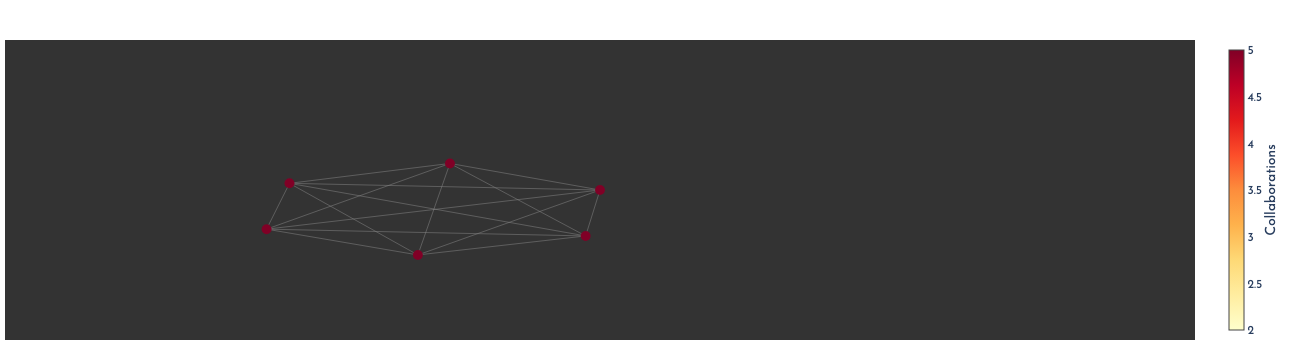

In [ ]:
fig.show()

In [ ]:
#|export
html_filename = "network_graph.html"
fig.write_html(f'{plots_dir}/{html_filename}')

Export all data to zip:

In [ ]:
#|export
if shutil.make_archive(f'{const.data_path}/{const.directory_name}', 'zip', f'{const.pre_output_path}'):
    print(f"All files saved to {const.data_path}/{const.directory_name}")